In [1]:
import pandas as pd
import astropy
from astropy.io import fits
import astropy.table
import seaborn as sns; sns.set()
import numpy as np
import os
import urllib.request


In [2]:
data_dir = "data"

# DR7 spectral
Note: for future reference, we could have gotten these directly from the sdss table `galSpecExtra`

In [4]:
metallicity_filename = os.path.join(data_dir, "gal_fiboh_dr7_v5_2.tmp.fits.gz")

if not os.path.exists(metallicity_filename):
    url = "https://wwwmpa.mpa-garching.mpg.de/SDSS/DR7/Data/gal_fiboh_dr7_v5_2.fits.gz"
    data = urllib.request.urlopen(url).read()
    with open(metallicity_filename, mode="wb") as f:
        f.write(data)
    
df_metallicity = astropy.table.Table.read(metallicity_filename).to_pandas()
print(df_metallicity.shape)
df_metallicity.head()

(927552, 8)


,MEDIAN,P16,P84,P2P5,P97P5,MODE,AVG,ENTROPY
0,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002
1,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002
2,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002
3,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002
4,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002,-99.900002


## Now add spec id's to the metallicities

In [5]:
spec_filename = os.path.join(data_dir, "SpecObjAll.fits")

if not os.path.exists(spec_filename):
    url = "http://home.strw.leidenuniv.nl/~jarle/SDSS/DR7/SpecObjAll.fits"
    data = urllib.request.urlopen(url).read()
    with open(spec_filename, mode="wb") as f:
        f.write(data)

df_spec = astropy.table.Table.read(spec_filename).to_pandas()
keys_to_keep = [key for key in df_spec.keys()
               if "ID" in key]
keys_to_keep.append("OBJTYPENAME")
keys_to_keep.append("SCIENCEPRIMARY") # 1 means good, 0 means bad
keys_to_keep.append("Z")
keys_to_keep.append("ZERR")
keys_to_keep.append("ZWARNING")
df_spec = df_spec[keys_to_keep]
df_spec.OBJTYPENAME = df_spec.OBJTYPENAME.apply(lambda x: x.strip().decode())

print(df_spec.shape)
df_spec.head()

(927552, 13)


,BESTOBJID,FIBERID,HTMID,PLATEID,SPECOBJID,SPECTROGRAPHID,TARGETID,TARGETOBJID,OBJTYPENAME,SCIENCEPRIMARY,Z,ZERR,ZWARNING
0,0,1,10570144490904,75093972707442688,75093972711636992,1,284722522357889,0,GALAXY,0,0.021314,0.000175,0
1,0,2,10570079934268,75093972707442688,75093972715831296,1,284722522489067,0,GALAXY,0,0.213991,0.000130,0
2,0,4,10570066101623,75093972707442688,75093972724219904,1,284705867301092,0,GALAXY,0,0.126660,0.000165,0
3,0,5,10570136564158,75093972707442688,75093972728414208,1,284705867235621,0,GALAXY,0,0.448533,0.000215,0
4,0,6,10552980740229,75093972707442688,75093972732608512,1,284723059360012,0,GALAXY,0,0.055957,0.000095,0


In [6]:
list(df_spec.keys())

['BESTOBJID',
 'FIBERID',
 'HTMID',
 'PLATEID',
 'SPECOBJID',
 'SPECTROGRAPHID',
 'TARGETID',
 'TARGETOBJID',
 'OBJTYPENAME',
 'SCIENCEPRIMARY',
 'Z',
 'ZERR',
 'ZWARNING']

In [7]:
df_spec.groupby("SCIENCEPRIMARY").size()

SCIENCEPRIMARY
0    123623
1    803929
dtype: int64

In [8]:
df = df_spec.join(df_metallicity)

df = df[df.MEDIAN > -20] # filter out bad fits
print("primary fraction: ", (df["SCIENCEPRIMARY"]==1).mean())
df = df[df["SCIENCEPRIMARY"] == 1]

print(df.shape)
df.head()

primary fraction:  0.8362790789040746
(170289, 21)


,BESTOBJID,FIBERID,HTMID,PLATEID,SPECOBJID,SPECTROGRAPHID,TARGETID,TARGETOBJID,OBJTYPENAME,SCIENCEPRIMARY,...,ZERR,ZWARNING,MEDIAN,P16,P84,P2P5,P97P5,MODE,AVG,ENTROPY
502,0,12,10552980740229,75094092966526976,75094093016858624,1,284723059360012,0,GALAXY,1,...,0.000095,0,9.011528,8.981688,9.038651,8.947308,9.080256,9.020000,9.022683,154.244042
504,0,14,10552986017956,75094092966526976,75094093025247232,1,284723059359915,0,GALAXY,1,...,0.000086,0,8.943193,8.923120,8.974710,8.865574,9.000556,8.960000,8.953361,164.798209
506,0,17,10570139305399,75094092966526976,75094093037830144,1,284705867169812,0,GALAXY,1,...,0.000183,0,9.052521,9.005045,9.075583,8.981743,9.114435,9.059999,9.056561,158.323309
514,0,27,10552961827699,75094092966526976,75094093079773184,1,284706404302990,0,GALAXY,1,...,0.000214,0,8.173073,8.039071,8.339158,7.947417,8.570580,8.160000,8.204945,43.245062
523,0,41,10570179932652,75094092966526976,75094093138493440,1,284722522292399,0,GALAXY,1,...,0.000103,0,9.136789,9.096197,9.154139,9.082401,9.159868,9.160000,9.137628,190.447896


In [9]:
# save the specobjid's so I can upload it to a sdss scratch tables

df[["SPECOBJID"]].drop_duplicates().to_csv("data/dr7_direct_specobjids.csv", index=False)
# even though I use `drop_duplicates`, it's actually unique already


In [10]:
df[["SPECOBJID"]].drop_duplicates().shape

(170289, 1)

## DR7 -> DR14 matches
SQL: 
```
SELECT 
  r.*,
  l.SPECOBJID as dr7_specObjID
FROM DR14.PhotoPrimaryDR7 as r
  INNER JOIN MyDB.DirectIDs as l
  ON r.SpecObjID = l.SPECOBJID
  ;
```

which was run on http://skyserver.sdss.org/CasJobs/SubmitJob.aspx

here `MyDB.DirectIDs` is just `df[["SPECOBJID"]].to_csv(...)`. `SPECOBJID` are unique in `MyDB.DirectIDs` but not in `DR14.PhotoPrimaryDR7` (but there will only be ~700 overlaps).


In [11]:
df_dr7dr14 = pd.read_csv(os.path.join(data_dir, "DR14_Photos.csv"))

df_dr7dr14 = df_dr7dr14.set_index("dr7_specObjID")
print(df_dr7dr14.shape)
df_dr7dr14.head()

(167988, 68)


,dr7objid,dr8objid,distance,skyVersion,run,rerun,camcol,field,obj,nChild,...,secTarget,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,htmID,fieldID,SpecObjID,size
dr7_specObjID,,,,,,,,,,,,,,,,,,,,,
349819130980859904,588015509294350376,1237645942905438473,0.000035,1,3325,41,4,489,40,0,...,0,1.050807,0.773173,0.560770,0.425215,0.301483,16656133296124,588015509294350336,349819130980859904,8.652516
116472201326100480,588015510365339781,1237645943976493208,0.000104,1,3325,41,6,447,133,0,...,0,0.601972,0.442925,0.321246,0.243591,0.172709,16645400403243,588015510365339648,116472201326100480,4.885514
116472201330294784,588015510365339757,1237645943976493287,0.000111,1,3325,41,6,447,109,0,...,0,0.624787,0.459712,0.333422,0.252824,0.179255,16645369720486,588015510365339648,116472201330294784,1.646459
116753554911264768,588015510365339765,1237645943976493290,0.000034,1,3325,41,6,447,117,0,...,0,0.609279,0.448302,0.325146,0.246548,0.174806,16645407457520,588015510365339648,116753554911264768,5.438163
117316118552510464,588015510367174876,1237645943978328289,0.000038,1,3325,41,6,475,220,0,...,0,0.461910,0.339869,0.246501,0.186915,0.132525,16635473087889,588015510367174656,117316118552510464,10.772990


In [12]:
df_dr7dr14.drop_duplicates().shape

(167988, 68)

In [13]:
df_dr7dr14.index.drop_duplicates().shape

(167206,)

In [14]:
df_dr7dr14.SpecObjID.drop_duplicates().shape

(167206,)

In [15]:
df.SPECOBJID

502        75094093016858624
504        75094093025247232
506        75094093037830144
514        75094093079773184
523        75094093138493440
529        75094093180436480
539        75094093243351040
544        75094093268516864
561        75094093356597248
565        75094093381763072
566        75094093385957376
568        75094093398540288
570        75094093406928896
572        75094093415317504
573        75094093419511808
603        75094093578895360
606        75094093599866880
608        75094093612449792
609        75094093616644096
611        75094093625032704
620        75094093671170048
624        75094093687947264
638        75094093759250432
646        75094093801193472
659        75094093868302336
665        75094093893468160
670        75094093927022592
671        75094093931216896
673        75094093939605504
700        75094094078017536
                 ...        
927403    837341053253058560
927410    837341053290807296
927414    837341053362110464
927416    8373

In [16]:
if "dr8objid" not in df:
    df_tmp = df.join(df_dr7dr14, on="SPECOBJID", how="inner")
    print(df_tmp.shape)
    print(df_tmp.SPECOBJID.drop_duplicates().shape)
    df = df_tmp

(167988, 89)
(167206,)


In [17]:
df.head()

,BESTOBJID,FIBERID,HTMID,PLATEID,SPECOBJID,SPECTROGRAPHID,TARGETID,TARGETOBJID,OBJTYPENAME,SCIENCEPRIMARY,...,secTarget,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,htmID,fieldID,SpecObjID,size
506,0,17,10570139305399,75094092966526976,75094093037830144,1,284705867169812,0,GALAXY,1,...,0,0.379354,0.279125,0.202445,0.153508,0.108839,10570139305399,587725073921540096,75094093037830144,4.297720
514,0,27,10552961827699,75094092966526976,75094093079773184,1,284706404302990,0,GALAXY,1,...,0,0.429550,0.316059,0.229232,0.173820,0.123240,10552961827696,587725074458673152,75094093079773184,5.687525
523,0,41,10570179932652,75094092966526976,75094093138493440,1,284722522292399,0,GALAXY,1,...,0,0.273461,0.201210,0.145934,0.110658,0.078458,10570179932652,588848898824273920,75094093138493440,8.377118
529,0,51,10570166742677,75094092966526976,75094093180436480,1,284722522292321,0,GALAXY,1,...,0,0.320851,0.236079,0.171224,0.129834,0.092054,10570166742677,588848898824273920,75094093180436480,4.254059
539,0,66,10552759033190,75094092966526976,75094093243351040,1,284723059294422,0,GALAXY,1,...,0,0.707734,0.520744,0.377687,0.286388,0.203053,10552759030425,588848899361275904,75094093243351040,3.969658


## Apply the cuts used by Wu and Boada

In [18]:
mask =  (df.modelMag_u > 10) & (df.modelMag_u < 25)
mask &= (df.modelMag_g > 10) & (df.modelMag_g < 25)
mask &= (df.modelMag_r > 10) & (df.modelMag_r < 25)
mask &= (df.modelMag_i > 10) & (df.modelMag_i < 25)
mask &= (df.modelMag_z > 10) & (df.modelMag_z < 25)

u_minus_r = df.modelMag_u - df.modelMag_r
mask &= (u_minus_r > 0) & (u_minus_r < 6)

mask &= (df.Z>.02)
mask &= (df.ZERR < .01)

mask &= (df.petroMag_r < 18)

mask &= df.ZWARNING==0

df = df[mask]

In [19]:
print(mask.mean())
print(mask.sum())

0.7794306736195442
130935


In [20]:
np.median(df.Z)

0.067944

In [21]:
df.Z.max()

0.366842

/Users/egentry/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


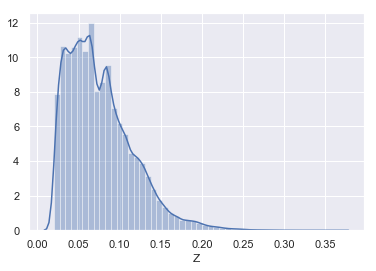

In [22]:
sns.distplot(df.Z)

## Final thing: deal with duplicates
Some `SpecObjID`s point to multiple photometry objects (<1\%).  This is problematic because that means an image / set of photometry points might appear in both the training and testing sets. To deal with this, especially since it's such a small fraction, **I'll just drop any rows with duplicate `SpecObjID`**.

In [23]:
df.shape

(130935, 89)

In [24]:
df.SpecObjID.drop_duplicates().shape

(130318,)

In [25]:
df.dr8objid.drop_duplicates().shape

(130935,)

In [26]:
df = df.drop_duplicates(
    subset="SpecObjID", 
    keep=False, # drop all rows that were duplicate -- don't keep any
)

df.shape

(129702, 89)

## Save to disk

In [27]:
feature_keys = [
    "modelMag_u",
    "modelMag_g",
    "modelMag_r",
    "modelMag_i",
    "modelMag_z",
]
features = df.set_index("SpecObjID")[feature_keys]

features.to_csv(os.path.join(data_dir, "features.csv"), index=True)

features.head()

,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
SpecObjID,,,,,
75094093037830144,19.04247,17.61871,16.96226,16.56983,16.33786
75094093138493440,18.53538,17.05057,16.26454,15.79881,15.46043
75094093180436480,17.41603,16.20129,15.53550,15.08500,14.81784
75094093243351040,19.17648,17.86717,17.17922,16.72164,16.46356
75094093398540288,20.04444,18.33195,17.63743,17.23082,16.91418


In [28]:
target_keys = [
    "MEDIAN"
]
targets = df.set_index("SpecObjID")[target_keys].rename(columns={"MEDIAN":"OH_median"})

targets.to_csv(os.path.join(data_dir, "targets.csv"), index=True)

targets.head()

,OH_median
SpecObjID,
75094093037830144,9.052521
75094093138493440,9.136789
75094093180436480,9.050070
75094093243351040,9.131351
75094093398540288,8.706560


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f393c18>]],
      dtype=object)

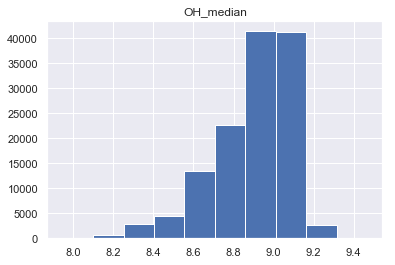

In [29]:
targets.hist()

In [31]:
df.to_csv(os.path.join(data_dir, "matched_galaxies.csv"),
          index=False)